In [1]:
import import_ipynb

from keras.layers import Input, Dense, Concatenate, MultiHeadAttention, Layer, LayerNormalization, GlobalAveragePooling1D, Dropout
from IPython.display import display, Image, update_display, HTML
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.regularizers import L1L2
from threading import Thread, Lock
from dataclasses import dataclass
import user_ad_interaction
import keras.backend as K
import tensorflow as tf
from queue import Queue
from tqdm import tqdm
import pandas as pd
import numpy as np
import bisect
import users
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]

In [3]:
user_model = user_ad_interaction.create_model()

In [4]:
ad_ftrs, num_categories, real_user_ftrs, _ = user_ad_interaction.load_user_and_ad_ftrs(root_directories)
user_pca_normal_params = users.approximate_normal_params(real_user_ftrs.T)

In [5]:
rating_to_exp_ctr = {
    1: 0.014925,
    2: 0.024786,
    3: 0.031071,
    4: 0.040562,
    5: 0.068341
}

mean_ctr = 0.02389

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50, 25)]     0           []                               
                                                                                                  
 text_input_dropout (Dropout)   (None, 50, 25)       0           ['text_input[0][0]']             
                                                                                                  
 transformer_block (Transformer  (None, 50, 25)      6932        ['text_input_dropout[0][0]']     
 Block)                                                                                           
                                                                                                  
 flat_input (InputLayer)        [(None, 20)]         0           []                         

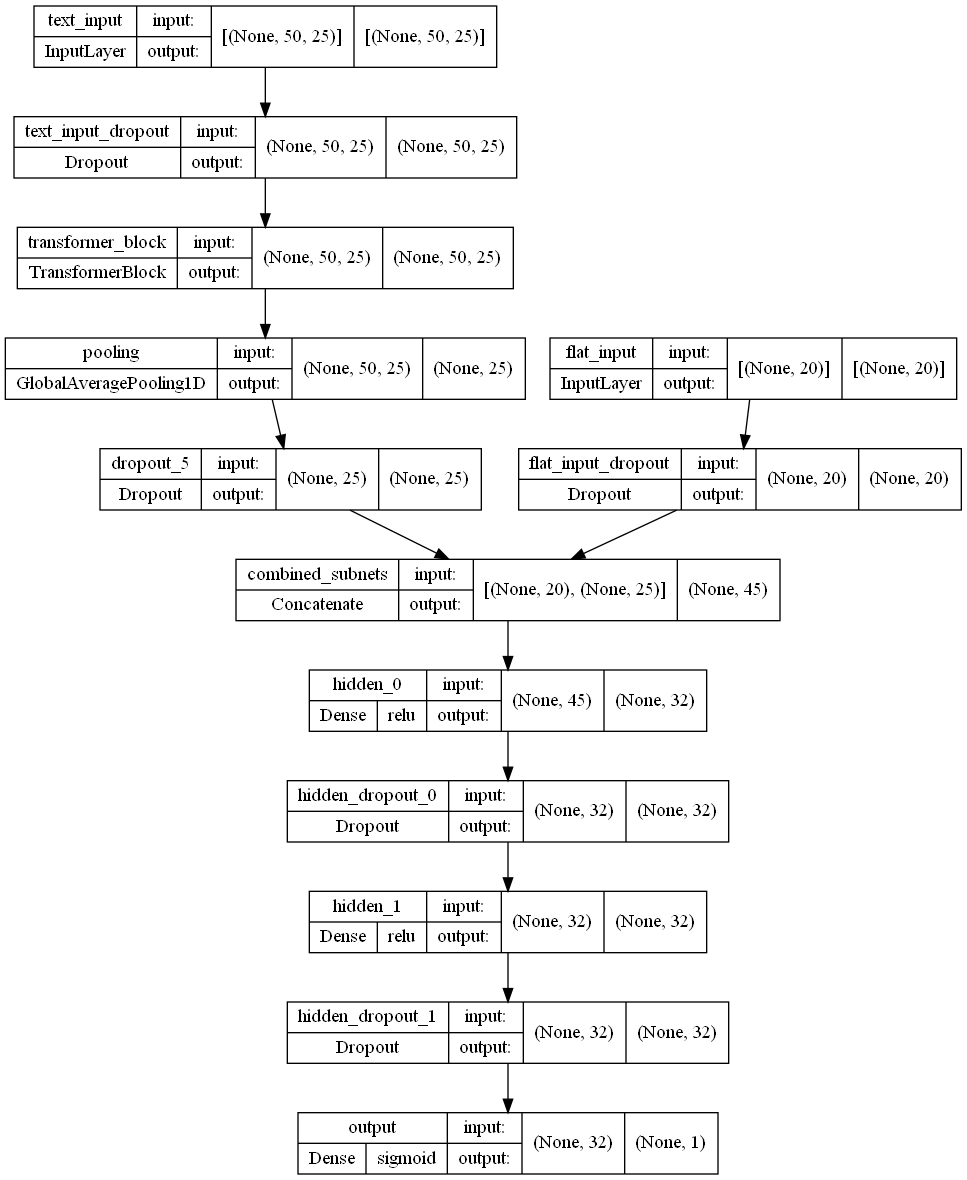

In [6]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class RLModel:
    def __init__(self, hp=None):
        inputs_1 = Input((ad_ftrs[0].shape[1]), name="flat_input")
        inputs_2 = Input(ad_ftrs[1].shape[1:], name="text_input")

        input_dropout_rate = 0.5 if hp is None else hp.Choice("input_dropout", values=[0.0, 0.1, 0.3, 0.5])
        subnet_1 = inputs_1 if input_dropout_rate == 0 else Dropout(input_dropout_rate, name="flat_input_dropout")(inputs_1)
        subnet_2 = inputs_2 if input_dropout_rate == 0 else Dropout(input_dropout_rate, name="text_input_dropout")(inputs_2)

        l1 = 1e-2 if hp is None else hp.Choice("l1", values=[1e-2, 1e-3, 1e-4])
        l2 = 1e-2 if hp is None else hp.Choice("l2", values=[1e-2, 1e-3, 1e-4])
        reg = L1L2(l1=l1, l2=l2)


        num_heads = 2 if hp is None else hp.Int("num_attn_heads", min_value=1, max_value=8, step=1)
        ff_dim = 32 if hp is None else hp.Int("ff_dim", min_value=32, max_value=128, step=32)
        dropout_rate = 0.5 if hp is None else hp.Choice("transformer_dropout_1", values=[0.0, 0.1, 0.3, 0.5])
        subnet_2 = TransformerBlock(embed_dim=ad_ftrs[1].shape[-1], num_heads=num_heads, ff_dim=ff_dim, rate=dropout_rate, name="transformer_block")(subnet_2)
        subnet_2 = GlobalAveragePooling1D(name="pooling")(subnet_2)
        dropout_rate = 0.5 if hp is None else hp.Choice("transformer_dropout_2", values=[0.0, 0.1, 0.3, 0.5])
        if dropout_rate != 0:
            subnet_2 = Dropout(dropout_rate)(subnet_2)

        output = Concatenate(name="combined_subnets")([subnet_1, subnet_2])

        num_hidden_layers = 2 if hp is None else hp.Int("num_hidden_layers", 1, 3)
        for i in range(num_hidden_layers):
            units = 32 if hp is None else hp.Int(f"units_{i}", min_value=32, max_value=128, step=32)
            output = Dense(units, activation="relu", kernel_regularizer=reg, name=f"hidden_{i}")(output)
            dropout_rate = 0.5 if hp is None else hp.Choice(f"dropout_{i}", values=[0.0, 0.1, 0.3, 0.5])
            if dropout_rate != 0:
                output = Dropout(dropout_rate, name=f"hidden_dropout_{i}")(output)


        output = Dense(1, activation="sigmoid", kernel_regularizer=reg, name="output")(output)

        self.model = Model(inputs=[inputs_1, inputs_2], outputs=[output])
        learning_rate = 1e-2 if hp is None else hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="binary_crossentropy"
        )
    
    def summary(self):
        self.model.summary()
        model_plot_filename = "data/tmp.png"
        plot_model(self.model, to_file=model_plot_filename, show_shapes=True, show_layer_activations=True, show_layer_names=True)
        display(Image(model_plot_filename))
        os.unlink(model_plot_filename)


RLModel().summary()

In [7]:
@dataclass
class RankedAd:
    ad_id: int
    value: float

    def __lt__(self, other):
        return self.value < other.value
    
    def __repr__(self):
        return f"{self.ad_id}{{{self.value}}}"

class Memory:
    def __init__(self, size=100):
        self.size = size
        self.ad_ftrs = (
            np.zeros((self.size, *ad_ftrs[0].shape[1:])),
            np.zeros((self.size, *ad_ftrs[1].shape[1:]))
        )
        self.rewards = np.zeros((self.size))
        self.ptr = 0
        self.full = False
    
    def store(self, ad_ftrs, reward):
        self.ad_ftrs[0][self.ptr] = ad_ftrs[0]
        self.ad_ftrs[1][self.ptr] = ad_ftrs[1]
        self.rewards[self.ptr] = reward

        self.ptr += 1
        if self.ptr >= self.size:
            self.full = True
            self.ptr = 0
    
    def get_training_data(self):
        if self.full:
            return (self.ad_ftrs, self.rewards)
        else:
            return ((self.ad_ftrs[0][:self.ptr], self.ad_ftrs[1][:self.ptr]), self.rewards[:self.ptr])

class User:
    def __init__(self):
        self.ftrs = users.generate_synthetic_pca_ftrs(1, user_pca_normal_params)[0]
        self.rl_model = RLModel()
        self.sorted_ads = []
        self.memory = Memory()
        self.sum_exp_reward = 0
    
    def get_true_exp_ctr(self, ad_ftrs):
        rating = np.argmax(user_model((np.concatenate([self.ftrs, ad_ftrs[0]])[np.newaxis], ad_ftrs[1][np.newaxis]))) + 1
        exp_ctr = rating_to_exp_ctr[rating]
        return exp_ctr

    def predict_reward(self, ad_id, ad_ftrs):
        exp_reward = self.rl_model.model((ad_ftrs[0][np.newaxis], ad_ftrs[1][np.newaxis]))[0,0]
        ra = RankedAd(ad_id, exp_reward)
        self.sum_exp_reward += exp_reward
        for i, existing_ad in enumerate(self.sorted_ads):
            if existing_ad.ad_id == ad_id:
                self.sum_exp_reward -= existing_ad.value
                del self.sorted_ads[i]
                break
        bisect.insort(self.sorted_ads, ra)
    
    def interact_with(self, ad_id, ad_ftrs):
        exp_ctr = self.get_true_exp_ctr(ad_ftrs)
        return np.random.uniform() <= exp_ctr
    
    def select_important_ad(self, p_random=0.1):
        if np.random.uniform() <= p_random or len(self.sorted_ads) == 0:
            return AdDatabase.get_random_ad()
        ad_id = self.sorted_ads[np.random.randint(0, len(self.sorted_ads))].ad_id
        return ad_id, AdDatabase.get_ad(ad_id)
    
    def select_ad(self, p_random=0.1):
        if np.random.uniform() <= p_random or self.sum_exp_reward == 0:
            return AdDatabase.get_random_ad()

        r = np.random.uniform(0, self.sum_exp_reward)
        s = 0
        for ad in self.sorted_ads[::-1]:
            s += ad.value
            if s >= r:
                return ad.ad_id, AdDatabase.get_ad(ad.ad_id)
        
        assert False
    
    def remember(self, ad_id, ad_ftrs, reward):
        self.memory.store(ad_ftrs, reward)
    
    def learn(self, rl_epochs=1, n_ads_to_fetch=10, p_random=0.1):
        self.rl_model.model.fit(
            *self.memory.get_training_data(),
            verbose=0,
            epochs=rl_epochs,
            batch_size=32
        )
        for _ in range(n_ads_to_fetch):
            ad = self.select_important_ad(p_random=p_random)
            self.predict_reward(*ad)


In [8]:
class AdDatabase:
    @staticmethod
    def get_ad(ad_id):
        return (ad_ftrs[0][ad_id], ad_ftrs[1][ad_id])

    @staticmethod
    def get_random_ad():
        ad_id = np.random.randint(len(ad_ftrs[0]))
        return ad_id, AdDatabase.get_ad(ad_id)


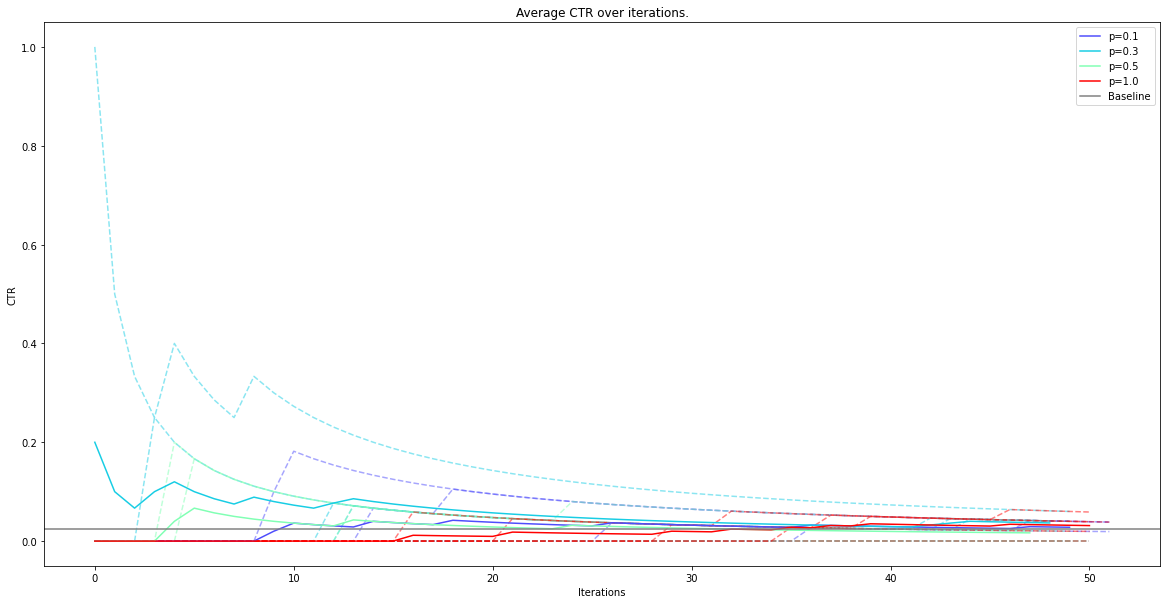

In [9]:
class Simulation(Thread):
    def __init__(self, sim_id, p_random=0.1):
        super().__init__(daemon=True)
        self.sim_id = sim_id
        self.user = User()
        self.killed = False
        self.p_random = p_random
        self.lock = Lock()
    
    def kill(self, blocking=True):
        if blocking:
            with self.lock:
                self.killed = True
        else:
            self.killed = True
    
    def run(self):
        while not self.killed:
            with self.lock:
                ad = self.user.select_ad(p_random=self.p_random)
                did_click = self.user.interact_with(*ad)
                
                self.user.remember(*ad, did_click)
                self.user.learn(p_random=self.p_random)

                if not self.killed:
                    q.put((self.sim_id, did_click))

q = Queue()

sims = []
clicks = []
dfs = []

num_sims = [
    (5, 0.1),
    (5, 0.3),
    (5, 0.5),
    (5, 1.0)
]

display(HTML("<h1>Running first iterations...</h1>"), display_id="graph")

i = 0
for n, p_random in num_sims:
    for _ in range(n):
        sims.append(Simulation(i, p_random=p_random))
        clicks.append([])
        dfs.append(pd.Series(dtype="float32"))
        i += 1

try:
    for s in sims:
        s.start()

    while True:
        sim_id, did_click = q.get()
        clicks[sim_id].append(did_click)
        # if len(clicks[sim_id]) <= rolling_window_size:
        dfs[sim_id] = pd.Series(clicks[sim_id]).expanding().mean()
        # else:
        #     dfs[sim_id] = pd.Series(clicks[sim_id]).rolling(rolling_window_size).mean()
        
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.patch.set_facecolor("white")

        by_p = {}
        for s in sims:
            p_random = round(s.p_random, 5)
            if p_random not in by_p:
                by_p[p_random] = []
            by_p[p_random].append(dfs[s.sim_id].values)

            ax.plot(dfs[s.sim_id], alpha=0.5, linestyle="dashed", color=cm.rainbow(p_random))
        
        for p_random in sorted(by_p.keys()):
            if len(by_p[p_random]) == 0:
                m = np.array([])
            else:
                max_len = max(len(x) for x in by_p[p_random])
                for i, x in enumerate(by_p[p_random]):
                    y = np.empty(max_len)
                    y[:len(x)] = x
                    y[len(x):] = np.nan
                    by_p[p_random][i] = y
                m = np.mean(np.stack(by_p[p_random]), axis=0)
            ax.plot(m, color=cm.rainbow(p_random), label=f"p={p_random}")
        
        ax.axhline(mean_ctr, c="grey", label="Baseline")

        ax.set_xlabel("Iterations")
        ax.set_ylabel("CTR")
        ax.set_title(f"Average CTR over iterations.")
        ax.legend()

        update_display(fig, display_id="graph")
        plt.close()

except KeyboardInterrupt:
    pass
finally:
    plt.close()
    for s in sims:
        s.kill(False)